## Модель оттока клиентов
### Описание
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Построем модель с предельно большим значением F1-меры. Чтобы считать проект успешным, нужно довести метрику до 0.59. Проверим F1-меру на тестовой выборке.
Дополнительно будем измерять AUC-ROC, сравнивайте её значение с F1-мерой.

### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
### Целевой признак
- Exited — факт ухода клиента

В ходе работы над проектом мы:
 1. Изучим данные и обработаем ошибки;
 2. Обучение модели без исправления дисбаланса;
 3. Обучение модели с исправлением дисбаланса;
 4. Лучшую модель машинного обучения протестируем на тестовой выборке;
 5. Сделаем глубокий вывод

## 1. Изучим данные и обработаем ошибки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

In [2]:
# отключаем некритичные предупреждения в коде
warnings.filterwarnings("ignore")

# сбрасываем ограничение на количество выводимых столбцов, что бы просмотреть все столбцы
pd.set_option('display.max_columns', None)

In [4]:
try:
    df = pd.read_csv('D:/Users/Иван/Downloads/Модель оттока клиентов/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')
                                 
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# получаем первые пять строк таблицы
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Думаю, пропущенные значения в **Tenure** значат, человек был клиентом банка менее года.

In [6]:
# заменим значения Nan в столбце Tenure на нуль
df['Tenure'] = df['Tenure'].fillna(0)
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
# статистика столбца Tenure
df['Tenure'].describe()

count    10000.000000
mean         4.543400
std          3.111573
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

In [9]:
# суммы значений столбца Tenure
df['Tenure'].value_counts()

Tenure
0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: count, dtype: int64

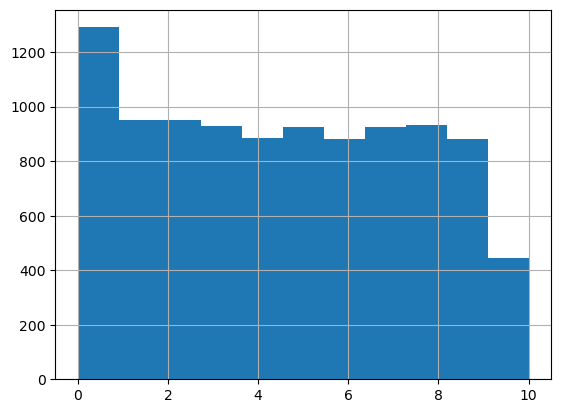

In [10]:
# гистограмма по столбцу Tenure
df['Tenure'].hist(bins=11)
plt.show()

Считаю, что распределение соответствует нормальному и количество клиентов сроком менее года вписывается в правдоподобную картину.

In [11]:
# Изучим страну проживания клиентов по столбцу Geography
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [12]:
# Рассмотрим соотношение пола клиентов по столбцу Gender
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

В таблице присутствуют столбцы, которые никак не влияют отток, но при обучении моделей могут негативным образом повлиять на результат. Столбец **RowNumber** повторяет индекс датафрейма. **CustomerId** - уникальный идентификатор клиента, который никак не зависит и не влиает на действия клиента банка. **Surname** - фамилия, признак, который как и идентификатор не может повлиять на то, клиент останется или уйдет. Их необходимо удалить.

In [13]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Чтобы избежать "ловушки фиктивных признаков" вызовем функцию **pd.get_dummies()** с аргументом **drop_first**:

In [14]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


In [15]:
# проверим на сбалансированность целевого признака
df_ohe['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Соотношение отрицательных и положительных признаков состовляет 1:4, что позволяет проводить обучение, но если не получится F1-меру довести до 0.59, то это скорее всего первое, что нужно исправить.

**ВЫВОД:**
1. Восстановили данные в столбце **Tenure**;
2. Удалили столбцы **Surname, RowNumber, CustomerId**;
3. Пресекли возможность "ловушки фиктивных признаков";
4. Проверили целевой признак на сбалансированность.

## 2. Машинное обучение без исправления дисбаланса:

In [16]:
# выделим целевой признак и обучающие выборки
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

In [17]:
# разделим выборки на обучающую, валидационную и тестовую
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=12345 )
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


In [18]:
# масштабирование признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Decision Tree Classifier

In [19]:
%%time

for depth in range(2, 30):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('Max depth', depth,'F1-score', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.5217391304347825 ROC_auc = 0.6898420629207774
Max depth 3 F1-score 0.4234875444839857 ROC_auc = 0.6344431069629021
Max depth 4 F1-score 0.5528700906344411 ROC_auc = 0.699620128357902
Max depth 5 F1-score 0.5406249999999999 ROC_auc = 0.6914510733793454
Max depth 6 F1-score 0.5683890577507599 ROC_auc = 0.7069332623594384
Max depth 7 F1-score 0.5440494590417311 ROC_auc = 0.6937753676225963
Max depth 8 F1-score 0.5509893455098934 ROC_auc = 0.6981759507376647
Max depth 9 F1-score 0.5742296918767508 ROC_auc = 0.716454249057882
Max depth 10 F1-score 0.5314285714285714 ROC_auc = 0.6921466982016585
Max depth 11 F1-score 0.5202156334231807 ROC_auc = 0.6894579570406306
Max depth 12 F1-score 0.5138339920948616 ROC_auc = 0.6871094671513861
Max depth 13 F1-score 0.5091863517060368 ROC_auc = 0.6846490723994216
Max depth 14 F1-score 0.5106918238993711 ROC_auc = 0.6878292876196929
Max depth 15 F1-score 0.5056039850560399 ROC_auc = 0.6853008426133719
Max depth 16 F1-score 0.503740

Лучший результат показала глубина 9

### Logistic Regression

In [20]:
model =  LogisticRegression(random_state=20052020, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1-score', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

F1-score 0.33389544688026984 ROC_auc = 0.5944008250715284


Результат логистической регрессии очень слабый, в дальнейшем, думаю, не стоит обращать на нее внимание...

### Random Forest

In [21]:
%%time

for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.5813253012048193 ROC_auc = 0.7141102958522614
N estimators 60 F1 0.5818181818181819 ROC_auc = 0.7138622904808279
N estimators 70 F1 0.5847076461769116 ROC_auc = 0.7161865847240789
N estimators 80 F1 0.5817091454272864 ROC_auc = 0.714674356849485
N estimators 90 F1 0.5863095238095238 ROC_auc = 0.7176307623443162
N estimators 100 F1 0.582089552238806 ROC_auc = 0.7152384178467084
N estimators 110 F1 0.5855855855855856 ROC_auc = 0.716502640349869
N estimators 120 F1 0.5808383233532933 ROC_auc = 0.7143583012236947
N estimators 130 F1 0.575301204819277 ROC_auc = 0.7110858401030735
N estimators 140 F1 0.5791855203619909 ROC_auc = 0.7129141236034575
N estimators 150 F1 0.5825825825825826 ROC_auc = 0.714990412475275
N estimators 160 F1 0.5813253012048193 ROC_auc = 0.7141102958522614
N estimators 170 F1 0.5907046476761619 ROC_auc = 0.7192110404732669
N estimators 180 F1 0.5919282511210762 ROC_auc = 0.7200911570962805
N estimators 190 F1 0.5877061469265367 ROC_auc = 0.7176988

Лучший результат показала модель с количеством деревьев 180 и результатом F1 - 0.5919.

### Gradient Boosting Classifier

In [22]:
# пробую подобрать параметры при помощи GridSearchCV

parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

gbc = GradientBoostingClassifier(random_state=12345)

clf_gbc = GridSearchCV(
    estimator = gbc,
    param_grid = parameters,
    scoring = 'f1',
    cv=5)
    
clf_gbc.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [23]:
%%time

model_base_gbc = clf_gbc.best_estimator_.fit(features_train, target_train)
predicted_test = model_base_gbc.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5586924219910847
ROC_auc: 0.7025646445430845
CPU times: total: 719 ms
Wall time: 758 ms


In [24]:
# пробую подобрать параметры при помощи цикла


for estimator in range(50, 300, 10):
    model =  GradientBoostingClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.5882352941176471 ROC_auc = 0.7152626134927019
N estimators 60 F1 0.5853658536585367 ROC_auc = 0.7151265129839885
N estimators 70 F1 0.5848484848484847 ROC_auc = 0.7153745183554219
N estimators 80 F1 0.5869894099848714 ROC_auc = 0.7165706906042256
N estimators 90 F1 0.5915915915915916 ROC_auc = 0.719527096099057
N estimators 100 F1 0.5910447761194029 ROC_auc = 0.7197751014704904
N estimators 110 F1 0.5925925925925927 ROC_auc = 0.7212192790907277
N estimators 120 F1 0.5920471281296024 ROC_auc = 0.7214672844621609
N estimators 130 F1 0.5906432748538012 ROC_auc = 0.7213992342078043
N estimators 140 F1 0.5982404692082112 ROC_auc = 0.7250558012085725
N estimators 150 F1 0.587719298245614 ROC_auc = 0.7198870063332103
N estimators 160 F1 0.5889212827988337 ROC_auc = 0.7207671229562241
N estimators 170 F1 0.5906432748538012 ROC_auc = 0.7213992342078043
N estimators 180 F1 0.5947521865889214 ROC_auc = 0.723791578705412
N estimators 190 F1 0.5979680696661829 ROC_auc = 0.72586

Лучший результат показала модель с количеством деревьев 260 и результатом F1 - 0.6060.

### CATBOOST
Подсмотрел на днях на Матемаркетинге у аналитика из альфабанка параметры этой модели, впечатлился его результатами F1-меры - 0.84, решил повторить его успех

In [25]:
#pip install catboost

In [26]:
from catboost import CatBoostClassifier, cv, Pool

In [27]:
# это я пробую, как сам разобрался
model = CatBoostClassifier(
    custom_loss=['F1'],
    random_seed=42,
    logging_level='Silent'
)

In [28]:
model.fit(
    features_train, target_train,
    eval_set=(features_valid, target_valid),
    plot=False
);
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

0.5960665658093798 ROC_auc = 0.7211073742280076


catboost тоже показал себя неплохо. Попробуем при помощи цикла.

In [31]:
%%time

for estimator in range(50, 300, 10):
    model =  CatBoostClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Learning rate set to 0.345342
0:	learn: 0.5383776	total: 2.02ms	remaining: 99.2ms
1:	learn: 0.4609563	total: 3.85ms	remaining: 92.4ms
2:	learn: 0.4156601	total: 5.41ms	remaining: 84.7ms
3:	learn: 0.3840232	total: 6.83ms	remaining: 78.5ms
4:	learn: 0.3679174	total: 8.3ms	remaining: 74.7ms
5:	learn: 0.3549115	total: 9.66ms	remaining: 70.8ms
6:	learn: 0.3467842	total: 10.9ms	remaining: 67.3ms
7:	learn: 0.3423639	total: 12.2ms	remaining: 64.1ms
8:	learn: 0.3350552	total: 13.3ms	remaining: 60.6ms
9:	learn: 0.3321412	total: 14.4ms	remaining: 57.5ms
10:	learn: 0.3298914	total: 15.6ms	remaining: 55.2ms
11:	learn: 0.3288516	total: 16.7ms	remaining: 53ms
12:	learn: 0.3231112	total: 17.9ms	remaining: 51ms
13:	learn: 0.3216694	total: 19.1ms	remaining: 49.1ms
14:	learn: 0.3203799	total: 20.2ms	remaining: 47.2ms
15:	learn: 0.3179059	total: 21.4ms	remaining: 45.5ms
16:	learn: 0.3172186	total: 22.6ms	remaining: 43.9ms
17:	learn: 0.3161895	total: 24ms	remaining: 42.7ms
18:	learn: 0.3137877	total: 25.4m

In [32]:
model =  CatBoostClassifier(random_state=20052020, n_estimators=270)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Learning rate set to 0.07356
0:	learn: 0.6333458	total: 2.63ms	remaining: 708ms
1:	learn: 0.5900946	total: 5ms	remaining: 670ms
2:	learn: 0.5507307	total: 7.23ms	remaining: 644ms
3:	learn: 0.5180538	total: 9.14ms	remaining: 608ms
4:	learn: 0.4926707	total: 11.7ms	remaining: 622ms
5:	learn: 0.4713433	total: 13.7ms	remaining: 602ms
6:	learn: 0.4481432	total: 15.7ms	remaining: 589ms
7:	learn: 0.4307162	total: 17.7ms	remaining: 579ms
8:	learn: 0.4157348	total: 19.6ms	remaining: 567ms
9:	learn: 0.4052123	total: 21.5ms	remaining: 558ms
10:	learn: 0.3966817	total: 23.7ms	remaining: 558ms
11:	learn: 0.3907778	total: 25.8ms	remaining: 554ms
12:	learn: 0.3821549	total: 27.6ms	remaining: 545ms
13:	learn: 0.3764687	total: 29.4ms	remaining: 538ms
14:	learn: 0.3713133	total: 31.4ms	remaining: 533ms
15:	learn: 0.3659856	total: 33.2ms	remaining: 527ms
16:	learn: 0.3597977	total: 35.1ms	remaining: 523ms
17:	learn: 0.3548951	total: 37ms	remaining: 518ms
18:	learn: 0.3519783	total: 39.1ms	remaining: 517m

N estimators 270 F1 0.6115942028985507 ROC_auc = 0.7331129513244092

In [33]:
# это с гиперпараметрами аналитика из альфабанка
params = {
    'iterations': 200,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent'
}
train_pool = Pool(features_train, target_train)
validate_pool = Pool(features_valid, target_valid)

In [34]:
cb = CatBoostClassifier(**params)
cb.fit(train_pool, eval_set=validate_pool)

print('Best model validation F1: {:.4}'.format(
#     accuracy_score(target_valid, best_model.predict(features_valid))
    f1_score(target_valid, cb.predict(features_valid))
))

Best model validation F1: 0.6077


Справедливости ради, у аналитика из альфабанка в датасете были такие столбца как платежи и переводы клиентов, возможно, именно они могли бы помочь показать лучшие результаты. Но и 0.6115 тоже весьма неплохо.

**ВЫВОД:**

В этой части проекта разделили выборки на тренировочные, валидационные и тестовые, произвели масштабирование цифровых признаков. Обученные модели показали такие результаты:
- **Decision Tree Classifier** с глубиной 9 показал F1 - 0.5742.
- **Random Forest**  с количеством деревьев 180 и результатом F1 - 0.5970.
- **Gradient Boosting Classifier** с количеством деревьев 260 и результатом F1 - 0.6060.
- **CATBOOST**  0.6115.

Таким образом без работы над дисбалансом лучший результат показал CatBoostClassifier.

## 2. Машинное обучение c исправлением дисбаланса:

## class_weight:

**Decision Tree**

In [35]:
%%time

for depth in range(2, 30):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('Max depth', depth,'F1-score', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.541015625 ROC_auc = 0.7273574120337045
Max depth 3 F1-score 0.541015625 ROC_auc = 0.7273574120337045
Max depth 4 F1-score 0.5277777777777778 ROC_auc = 0.7337087691069992
Max depth 5 F1-score 0.5963791267305644 ROC_auc = 0.7587588238496482
Max depth 6 F1-score 0.5581835383159887 ROC_auc = 0.7441476781253213
Max depth 7 F1-score 0.5545545545545546 ROC_auc = 0.735258802678458
Max depth 8 F1-score 0.5385365853658537 ROC_auc = 0.7255291285333204
Max depth 9 F1-score 0.5299313052011776 ROC_auc = 0.7183520950404975
Max depth 10 F1-score 0.5236714975845409 ROC_auc = 0.7148074329024492
Max depth 11 F1-score 0.5306122448979592 ROC_auc = 0.7155559857003732
Max depth 12 F1-score 0.5071868583162218 ROC_auc = 0.6977933570853925
Max depth 13 F1-score 0.5026852846401718 ROC_auc = 0.6917247866246469
Max depth 14 F1-score 0.47704367301231804 ROC_auc = 0.6719781150381989
Max depth 15 F1-score 0.47465437788018433 ROC_auc = 0.6692939105607946
Max depth 16 F1-score 0.4775413711583924 

Decision Tree неожиданно при глубине 5 выдал F1-score 0.5963, что довольно неплохо.

**RandomForestClassifier**

In [36]:
%%time

for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))


N estimators 50 F1 0.5570776255707762 ROC_auc = 0.7012004064868527
N estimators 60 F1 0.5627836611195158 ROC_auc = 0.704472867607474
N estimators 70 F1 0.5592705167173253 ROC_auc = 0.7023965787356565
N estimators 80 F1 0.5688350983358548 ROC_auc = 0.7074973233566619
N estimators 90 F1 0.5666666666666667 ROC_auc = 0.7063011511078582
N estimators 100 F1 0.5570776255707762 ROC_auc = 0.7012004064868527
N estimators 110 F1 0.5565749235474006 ROC_auc = 0.700636345489629
N estimators 120 F1 0.5613496932515338 ROC_auc = 0.7027806846158033
N estimators 130 F1 0.5644171779141105 ROC_auc = 0.7042929124903974
N estimators 140 F1 0.566615620214395 ROC_auc = 0.7054890847392011
N estimators 150 F1 0.5718654434250765 ROC_auc = 0.708197484862599
N estimators 160 F1 0.5727411944869832 ROC_auc = 0.7085135404883891
N estimators 170 F1 0.5688073394495413 ROC_auc = 0.706685256988005
N estimators 180 F1 0.5696784073506891 ROC_auc = 0.7070013126137951
N estimators 190 F1 0.5740458015267176 ROC_auc = 0.7093936

N estimators 260 F1 0.5827 ROC_auc = 0.7141

**Logistic Regression**

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 290 F1 0.4888888888888888 ROC_auc = 0.6948233415396898


Для логистической регрессии с параметром class_weight = 'balanced' стало на много лучше.

### UPSAMPLE и DOWNSAMPLE

Создадим функцию **upsample** для увеличения отрицательных признаков и **downsample** для уменьшения отрицательных признаков:

In [38]:
# Уменьшение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# увеличение обучающей выбоки
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# проверка размера после upsample
features_zeros = features_upsampled[target_upsampled == 0]
features_ones = features_upsampled[target_upsampled == 1]
target_zeros = features_upsampled[target_upsampled == 0]
target_ones = features_upsampled[target_upsampled == 1]

print(features_zeros.shape[0])
print(features_ones.shape[0])

# Увеличение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# 
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# проверка размера после upsample
features_zeros = features_downsampled[target_downsampled == 0]
features_ones = features_downsampled[target_downsampled == 1]
target_zeros = features_downsampled[target_downsampled == 0]
target_ones = features_downsampled[target_downsampled == 1]

print(features_zeros.shape[0])
print(features_ones.shape[0])

4804
4784
1201
1196


**Decision Tree Classifier**

In [39]:
# Обучение на выборке upsampled

for depth in range(2, 30):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('Max depth', depth,'F1-score', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.541015625 ROC_auc = 0.7273574120337045
Max depth 3 F1-score 0.541015625 ROC_auc = 0.7273574120337045
Max depth 4 F1-score 0.5277777777777778 ROC_auc = 0.7337087691069992
Max depth 5 F1-score 0.5963791267305644 ROC_auc = 0.7587588238496482
Max depth 6 F1-score 0.5581835383159887 ROC_auc = 0.7441476781253213
Max depth 7 F1-score 0.5571142284569138 ROC_auc = 0.7370870861788421
Max depth 8 F1-score 0.5386875612144956 ROC_auc = 0.725281123161887
Max depth 9 F1-score 0.5299313052011776 ROC_auc = 0.7183520950404975
Max depth 10 F1-score 0.5206286836935168 ROC_auc = 0.7111070112933178
Max depth 11 F1-score 0.5238578680203045 ROC_auc = 0.7109512518222347
Max depth 12 F1-score 0.5195353748680043 ROC_auc = 0.7048146311071323
Max depth 13 F1-score 0.5038503850385039 ROC_auc = 0.6911168710190602
Max depth 14 F1-score 0.4921700223713647 ROC_auc = 0.6822476545345665
Max depth 15 F1-score 0.485981308411215 ROC_auc = 0.6761110338194641
Max depth 16 F1-score 0.4845605700712589 ROC

In [40]:
# Обучение на выборке downsampled

for depth in range(2, 30):
    model = DecisionTreeClassifier(random_state=20052020, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print('Max depth', depth,'F1-score', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.5394495412844036 ROC_auc = 0.7322056145996528
Max depth 3 F1-score 0.5555555555555556 ROC_auc = 0.7406952618876234
Max depth 4 F1-score 0.5357737104825291 ROC_auc = 0.7391497649997882
Max depth 5 F1-score 0.5931174089068827 ROC_auc = 0.762931060555653
Max depth 6 F1-score 0.5738636363636362 ROC_auc = 0.7565615567478632
Max depth 7 F1-score 0.5295169946332737 ROC_auc = 0.7263805128267168
Max depth 8 F1-score 0.5301204819277109 ROC_auc = 0.7235844034865925
Max depth 9 F1-score 0.5322283609576427 ROC_auc = 0.7259086977298436
Max depth 10 F1-score 0.5261194029850746 ROC_auc = 0.7197478813687477
Max depth 11 F1-score 0.5125448028673836 ROC_auc = 0.7118903453323574
Max depth 12 F1-score 0.4937833037300177 ROC_auc = 0.6966319660777043
Max depth 13 F1-score 0.49107901444350044 ROC_auc = 0.6971476357829409
Max depth 14 F1-score 0.4844928751047779 ROC_auc = 0.6920907457702987
Max depth 15 F1-score 0.4991452991452991 ROC_auc = 0.7038967087872536
Max depth 16 F1-score 0.4945

Лучший результат на выборке **upsampled** — F1-score 0.5963, а на **downsampled** — F1-score 0.5931, что почти не отличается по результату от class_weight = 'balanced'

**Random Forest**

In [41]:
# Обучение на выборке upsampled
for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, class_weight = 'balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.6058201058201058 ROC_auc = 0.7394733817649514
N estimators 60 F1 0.610079575596817 ROC_auc = 0.7416177208911258
N estimators 70 F1 0.5944517833553501 ROC_auc = 0.7331084146407854
N estimators 80 F1 0.6042216358839051 ROC_auc = 0.7388412705133711
N estimators 90 F1 0.6034255599472992 ROC_auc = 0.7385252148875809
N estimators 100 F1 0.6013245033112583 ROC_auc = 0.7367649816415536
N estimators 110 F1 0.5994694960212201 ROC_auc = 0.7355688093927498
N estimators 120 F1 0.5938748335552596 ROC_auc = 0.7319802926463383
N estimators 130 F1 0.5927903871829105 ROC_auc = 0.7311001760233246
N estimators 140 F1 0.5924932975871314 ROC_auc = 0.7305361150261009
N estimators 150 F1 0.5917001338688086 ROC_auc = 0.7302200594003109
N estimators 160 F1 0.600265604249668 ROC_auc = 0.7358848650185399
N estimators 170 F1 0.601063829787234 ROC_auc = 0.7362009206443301
N estimators 180 F1 0.600265604249668 ROC_auc = 0.7358848650185399
N estimators 190 F1 0.5992010652463382 ROC_auc = 0.735004

In [42]:
# Обучение на выборке downsampled
for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=20052020, n_estimators=estimator, class_weight = 'balanced')
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.5719661335841957 ROC_auc = 0.7558613952419261
N estimators 60 F1 0.5684995340167753 ROC_auc = 0.7542130668586187
N estimators 70 F1 0.5813084112149532 ROC_auc = 0.764234600983553
N estimators 80 F1 0.5762394761459307 ROC_auc = 0.7600139729855613
N estimators 90 F1 0.5730232558139535 ROC_auc = 0.7581176392308204
N estimators 100 F1 0.5727525486561632 ROC_auc = 0.7583656446022539
N estimators 110 F1 0.5786046511627907 ROC_auc = 0.7626543228546023
N estimators 120 F1 0.5837231057062675 ROC_auc = 0.7660628844839371
N estimators 130 F1 0.5845004668534081 ROC_auc = 0.7669430011069508
N estimators 140 F1 0.5866916588566073 ROC_auc = 0.7682072236101113
N estimators 150 F1 0.57703081232493 ROC_auc = 0.7608940896085751
N estimators 160 F1 0.5838739573679332 ROC_auc = 0.7674390118498176
N estimators 170 F1 0.5788497217068646 ROC_auc = 0.7632183838518258
N estimators 180 F1 0.5809435707678076 ROC_auc = 0.7652946727236434
N estimators 190 F1 0.5841860465116279 ROC_auc = 0.76719

Лучший результат на выборке upsampled — F1 0.6071, а на downsampled — F1 0.5880, что значительно отличается по результату от class_weight = 'balanced' и составлял F1 0.4514.

**Logistic Regression**

In [43]:
# Обучение на выборке upsampled
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 290 F1 0.4875962360992301 ROC_auc = 0.6936271692908861


In [44]:
# Обучение на выборке downsampled
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 290 F1 0.4892703862660944 ROC_auc = 0.6948913917940466


**Gradient Boosting Classifier**

In [45]:
# Обучение на выборке upsampled
for estimator in range(50, 300, 10):
    model =  GradientBoostingClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.6104651162790696 ROC_auc = 0.7822936262619542
N estimators 60 F1 0.6124031007751938 ROC_auc = 0.7838058541365481
N estimators 70 F1 0.6091173617846751 ROC_auc = 0.7810974540131503
N estimators 80 F1 0.6093750000000001 ROC_auc = 0.7802853876444933
N estimators 90 F1 0.6103012633624879 ROC_auc = 0.7817295652647306
N estimators 100 F1 0.6140350877192983 ROC_auc = 0.784189960016695
N estimators 110 F1 0.613880742913001 ROC_auc = 0.7836258990194713
N estimators 120 F1 0.611328125 ROC_auc = 0.7817976155190873
N estimators 130 F1 0.6119257086999024 ROC_auc = 0.7821136711448775
N estimators 140 F1 0.608780487804878 ROC_auc = 0.7799693320187031
N estimators 150 F1 0.6072477962781587 ROC_auc = 0.7782090987726759
N estimators 160 F1 0.6094674556213018 ROC_auc = 0.778909260278613
N estimators 170 F1 0.6061204343534059 ROC_auc = 0.7762008601552151
N estimators 180 F1 0.6067193675889329 ROC_auc = 0.7765169157810052
N estimators 190 F1 0.6053412462908012 ROC_auc = 0.7753207435322

In [46]:
# Обучение на выборке downsampled
for estimator in range(50, 300, 10):
    model =  GradientBoostingClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

N estimators 50 F1 0.5971830985915493 ROC_auc = 0.7764004742346614
N estimators 60 F1 0.5996204933586338 ROC_auc = 0.7768526303691652
N estimators 70 F1 0.5975261655566128 ROC_auc = 0.7747763414973476
N estimators 80 F1 0.5918944392082941 ROC_auc = 0.7716157852394462
N estimators 90 F1 0.5897920604914935 ROC_auc = 0.7695394963676286
N estimators 100 F1 0.590009425070688 ROC_auc = 0.7701035573648523
N estimators 110 F1 0.5883458646616542 ROC_auc = 0.7691553904874817
N estimators 120 F1 0.5837231057062675 ROC_auc = 0.7660628844839371
N estimators 130 F1 0.5876865671641791 ROC_auc = 0.7696514012303486
N estimators 140 F1 0.5902255639097744 ROC_auc = 0.7706676183620758
N estimators 150 F1 0.583955223880597 ROC_auc = 0.7666269454811606
N estimators 160 F1 0.5844155844155845 ROC_auc = 0.7677550674756078
N estimators 170 F1 0.5751152073732718 ROC_auc = 0.7610059944712949
N estimators 180 F1 0.5803489439853076 ROC_auc = 0.7657906834665101
N estimators 190 F1 0.5792850595783685 ROC_auc = 0.7651

Лучший результат на выборке upsampled — F1 0.6124, а на downsampled — F1 0.5996 при том, что до балансировки признаков лучший результат состовлял F1 0.6060

**CATBOOST**

In [48]:
# Обучение на выборке upsampled
for estimator in range(50, 300, 10):
    model =  CatBoostClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Learning rate set to 0.421868
0:	learn: 0.5827432	total: 2.51ms	remaining: 123ms
1:	learn: 0.5221372	total: 5.64ms	remaining: 135ms
2:	learn: 0.4918441	total: 7.87ms	remaining: 123ms
3:	learn: 0.4769610	total: 9.93ms	remaining: 114ms
4:	learn: 0.4646223	total: 11.9ms	remaining: 108ms
5:	learn: 0.4558396	total: 13.8ms	remaining: 101ms
6:	learn: 0.4497398	total: 15.5ms	remaining: 95.1ms
7:	learn: 0.4470285	total: 17ms	remaining: 89.3ms
8:	learn: 0.4444594	total: 18.4ms	remaining: 83.9ms
9:	learn: 0.4411762	total: 19.9ms	remaining: 79.6ms
10:	learn: 0.4327683	total: 21.4ms	remaining: 76ms
11:	learn: 0.4308543	total: 22.9ms	remaining: 72.6ms
12:	learn: 0.4281694	total: 24.4ms	remaining: 69.3ms
13:	learn: 0.4251943	total: 25.8ms	remaining: 66.2ms
14:	learn: 0.4215275	total: 27.1ms	remaining: 63.2ms
15:	learn: 0.4185317	total: 28.4ms	remaining: 60.3ms
16:	learn: 0.4170711	total: 29.7ms	remaining: 57.6ms
17:	learn: 0.4154837	total: 31ms	remaining: 55.1ms
18:	learn: 0.4119039	total: 32.3ms	rem

In [49]:
# Обучение на выборке downsampled
for estimator in range(50, 300, 10):
    model =  CatBoostClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print('N estimators', estimator,'F1', f1_score(target_valid, predicted_valid), 'ROC_auc =', 
          roc_auc_score(target_valid, predicted_valid))

Learning rate set to 0.233398
0:	learn: 0.6334269	total: 1.59ms	remaining: 78.1ms
1:	learn: 0.5903813	total: 3.02ms	remaining: 72.4ms
2:	learn: 0.5594574	total: 4.64ms	remaining: 72.7ms
3:	learn: 0.5348559	total: 6.13ms	remaining: 70.5ms
4:	learn: 0.5169047	total: 7.71ms	remaining: 69.4ms
5:	learn: 0.5019286	total: 9.17ms	remaining: 67.3ms
6:	learn: 0.4924290	total: 10.8ms	remaining: 66ms
7:	learn: 0.4859690	total: 12.5ms	remaining: 65.9ms
8:	learn: 0.4798529	total: 14.3ms	remaining: 65.4ms
9:	learn: 0.4759908	total: 16.1ms	remaining: 64.5ms
10:	learn: 0.4677766	total: 17.8ms	remaining: 63ms
11:	learn: 0.4635496	total: 19.5ms	remaining: 61.8ms
12:	learn: 0.4610014	total: 21.2ms	remaining: 60.4ms
13:	learn: 0.4567290	total: 23.1ms	remaining: 59.4ms
14:	learn: 0.4512811	total: 24.7ms	remaining: 57.7ms
15:	learn: 0.4478313	total: 26.2ms	remaining: 55.7ms
16:	learn: 0.4459061	total: 27.6ms	remaining: 53.5ms
17:	learn: 0.4424994	total: 28.8ms	remaining: 51.2ms
18:	learn: 0.4386098	total: 30

Лучший результат на выборке upsampled — estimators 150 F1 0.6217 ROC_auc = 0.7877, а на downsampled — estimators 60 F1 0.6098 ROC_auc = 0.7819 при том, что до балансировки признаков лучший результат состовлял F1 0.6115

**ВЫВОД:**

В данной части исследования мы провели балансировку данных при помощи **class_weight, upsample и downsample**Во всех моделях замечено лучшее качество обучения на увеличенной выборке **upsampled**. Как и на не сбалансированных данных, лучшей себя показала модель **CatBoostClassifier** выдав результат F1 0.6217, ROC-auc = 0.7877.

## Тестирование лучшей модели

In [50]:
for estimator in range(50, 300, 10):
    model =  CatBoostClassifier(random_state=20052020, n_estimators=estimator)
    model.fit(features_upsampled, target_upsampled)
    predicted_test = model.predict(features_test)
    print('N estimators', estimator,'F1', f1_score(target_test, predicted_test), 'ROC_auc =', 
          roc_auc_score(target_test, predicted_test))

Learning rate set to 0.421868
0:	learn: 0.5827432	total: 1.33ms	remaining: 65.3ms
1:	learn: 0.5221372	total: 6.84ms	remaining: 164ms
2:	learn: 0.4918441	total: 12.7ms	remaining: 198ms
3:	learn: 0.4769610	total: 18ms	remaining: 207ms
4:	learn: 0.4646223	total: 21.9ms	remaining: 197ms
5:	learn: 0.4558396	total: 26.5ms	remaining: 194ms
6:	learn: 0.4497398	total: 29.7ms	remaining: 183ms
7:	learn: 0.4470285	total: 31.6ms	remaining: 166ms
8:	learn: 0.4444594	total: 33.4ms	remaining: 152ms
9:	learn: 0.4411762	total: 35.2ms	remaining: 141ms
10:	learn: 0.4327683	total: 36.8ms	remaining: 131ms
11:	learn: 0.4308543	total: 38.4ms	remaining: 122ms
12:	learn: 0.4281694	total: 39.8ms	remaining: 113ms
13:	learn: 0.4251943	total: 41.1ms	remaining: 106ms
14:	learn: 0.4215275	total: 42.5ms	remaining: 99.1ms
15:	learn: 0.4185317	total: 43.8ms	remaining: 93ms
16:	learn: 0.4170711	total: 45.1ms	remaining: 87.5ms
17:	learn: 0.4154837	total: 46.3ms	remaining: 82.4ms
18:	learn: 0.4119039	total: 47.6ms	remainin

При количестве деревьев 110 F1-метрика 0.6276, ROC-auc = 0.7701.

**Проверка на адекватность:**

In [51]:
strategies = ['most_frequent', 'stratified', 'uniform']
test_scores = []

for s in strategies:
    dummy_clf = DummyClassifier(strategy=s, random_state=12345)
    dummy_clf.fit(features_upsampled, target_upsampled)
    score = dummy_clf.score(features_test,  target_test)
    predict = dummy_clf.predict(features_test)
    f1 = f1_score(target_test, predict)
    test_scores.append(f1)
    
print(test_scores)
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()

[0.0, 0.28288543140028294, 0.2914923291492329]


TypeError: stripplot() takes from 0 to 1 positional arguments but 2 were given

## ВЫВОД:

В ходе работы над проектом:
 1. Изучили данные и обработали ошибки;
 2. Обучили модели без исправления дисбаланса;
 3. Обучили модели с исправлением дисбаланса;
 4. Лучшую модель машинного обучения протестировали на тестовой выборке;
 5. Сделали глубокий вывод.
 
В условиях нашего датасета и балансирования методом upsampled лучшей себя показала модель от Яндекса, **CatBoost** с результатом F1 = 0.6276. Уверен, что если наш датасет обогатить данными с переводами и платежами клиентов, можно будет улучшить метрики минимум на 20%.